# Distances

**Resources**

* High-Performance Computation in Python | Numpy - [Blog](https://semantive.com/blog/high-performance-computation-in-python-numpy-2/)

$$d(u,v) = \sqrt{\sum_{i=1}^N(u_i - v_i)^2}$$

In [1]:
#@title Packages
import functools

import jax
import jax.numpy as jnp
import numpy as onp
from sklearn.metrics.pairwise import euclidean_distances, haversine_distances
from sklearn import datasets

# Plotting libraries
import matplotlib.pyplot as plt
plt.style.use(['seaborn-paper'])

In [2]:
#@title Plot Functions

def plot_kernel_mat(K):
    # plot
    plt.figure()
    plt.imshow(K, cmap='Reds')
    plt.title(r'$K_{ff}$, (rbf)', fontsize=20, weight='bold')
    plt.tight_layout()
    plt.show()

In [3]:
#@title Data

def get_1d_data(N=30, sigma_inputs=0.15, sigma_obs=0.15, N_test=400):
    onp.random.seed(0)
    X = jnp.linspace(-10, 10, N)
    # Y = X + 0.2 * np.power(X, 3.0) + 0.5 * np.power(0.5 + X, 2.0) * np.sin(4.0 * X)
    Y = jnp.sin(1.0 * jnp.pi / 1.6 * jnp.cos(5 + .5 * X))
    Y += sigma_obs * onp.random.randn(N)
    X += sigma_inputs * onp.random.randn(N)
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)



    X_test = jnp.linspace(-11, 11, N_test) 
    X_test += sigma_inputs * onp.random.randn(N_test)

    X = X[:, None]
    X_test = X[:, None]

    assert X.shape == (N,1)
    assert Y.shape == (N,)

    return X, Y, X_test

def get_2d_data(N=30, sigma_obs=0.15, N_test=400):
    onp.random.seed(0)
    X1 = jnp.linspace(-10, 10, N)
    X2 = jnp.linspace(-5, 2, N)
    # Y = X + 0.2 * np.power(X, 3.0) + 0.5 * np.power(0.5 + X, 2.0) * np.sin(4.0 * X)
    Y = jnp.sin(1.0 * jnp.pi / 1.6 * jnp.cos(5 + .5 * X1)) + jnp.exp(X2)
    Y += sigma_obs * onp.random.randn(N)
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)



    X1_test = jnp.linspace(-11, 11, N_test)
    X2_test = jnp.linspace(-6, 4, N_test) 

    X = jnp.vstack((X1,X2)).T
    X_test = jnp.vstack((X1_test,X2_test)).T

    assert X.shape == (N,2)
    assert Y.shape == (N,)

    return X, Y, X_test

# Get Data
X, Y, X_test = get_1d_data(100, sigma_inputs=0.0, sigma_obs=0.1, N_test=100)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Squared Euclidean Distance

In [4]:
#@title Kernel Functions

# Squared Euclidean Distance Formula
# @jax.jit
# def sqeuclidean_distance(x, y):
#     z = x - y
#     return jnp.einsum("i,i->", z, z)

@jax.jit
def sqeuclidean_distance(x, y):
    return jnp.linalg.norm(x - y)**2
#     return jnp.sum( (x - y) ** 2)


# @jax.jit
# def sqeuclidean_distance_vect(x, y):
#     return jnp.linalg.norm(x - y, axis=1)**2
#     return jnp.sum( (x - y) ** 2)
# @jax.jit
# def sqeuclidean_distance(x, y):

#     return jnp.sum( (x - y) ** 2)

# @jax.jit
def gram(func, x, y):
    return jax.vmap(lambda x1: jax.vmap(lambda y1: func(x1, y1))(x))(y)

In [5]:
# X, Y, X_test = get_2d_data(1_000, sigma_obs=0.1)
X, y = datasets.make_regression(1_000, 10)

X_ = jnp.array(X)
type(X_), X_.shape

(jax.interpreters.xla.DeviceArray, (1000, 10))

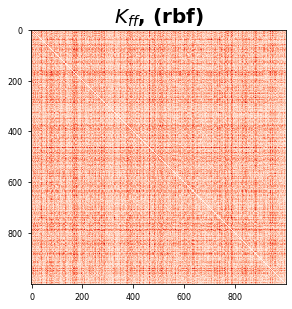

In [6]:
test_X = X.copy()#[:2, :]
test_Y = X.copy() #[:2, :]

dist_x_sk = euclidean_distances(
    onp.array(test_X), 
    onp.array(test_Y), 
    squared=True
)
euclidean_mat = jax.jit(functools.partial(gram, sqeuclidean_distance))

dist_x = euclidean_mat(
    test_X, 
    test_Y
)

onp.testing.assert_array_almost_equal(onp.array(dist_x), dist_x_sk, decimal=1e-5)

plot_kernel_mat(dist_x)

### Speed Test

In [7]:
%timeit _ = euclidean_distances(X, X, squared=True)
%timeit _ = euclidean_mat(X_, X_)

6.75 ms ± 58.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
491 µs ± 3.16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Haversine Distance